In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import ssl

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.7.1
Populating the interactive namespace from numpy and matplotlib


In [2]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

google = pdr.DataReader('005930', 'naver', start, end) # yahoo 안불러와져서 예제와는 다르게 naver로 진행

In [3]:
google = google.apply(pd.to_numeric)
google = google[(google['Low']>1000)]

In [4]:
google

,Open,High,Low,Close,Volume
Date,,,,,
2000-12-01,3080,3220,3040,3180,1928557
2000-12-04,3220,3250,3080,3100,1037540
2000-12-05,3160,3250,3120,3240,1168095
2000-12-06,3410,3430,3210,3210,1917834
2000-12-07,3210,3260,3160,3260,860422
...,...,...,...,...,...
2022-02-04,74300,74600,73400,74000,12730034
2022-02-07,73500,73600,72400,73000,14240838
2022-02-08,73800,74200,73000,73500,11736666


<AxesSubplot:xlabel='Date'>

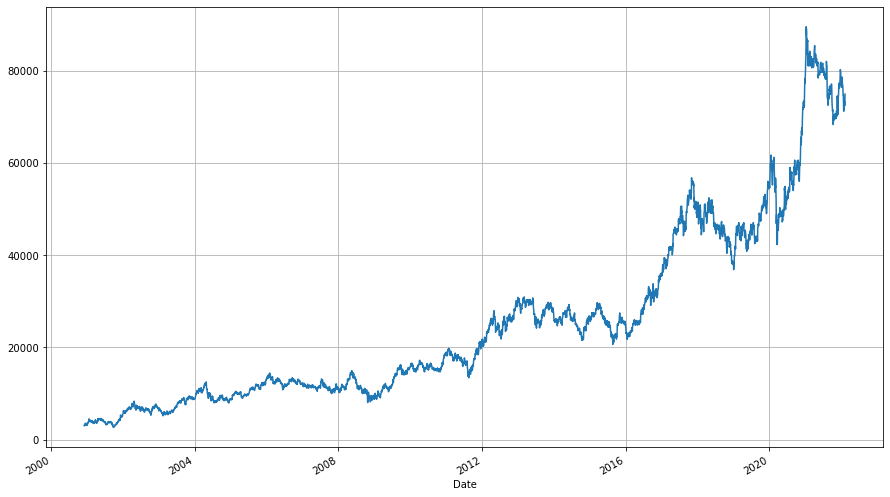

In [5]:
google.Low.plot(grid=True)

# Data Preparation

## 커스텀데이터셋 만들기
- Dataset: i번째 레코드 값을 주는 역할을 함 
 : 데이터 요청을 받으면 데이터를 꺼내줌
- DataLoader: 배치 만들어주는 역할 (Chunking) 
- DataLoader에다가 Dataset을 넣어주면 배치사이즈대로 데이터를 뽑아줌 
- 커스텀데이터셋인데 length 및 indexing이 가능함

In [6]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end): #x_frame: x_seq_len(최근 n일), y_frames(이후 n일): y_seq_len
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = pdr.DataReader(self.symbol, 'naver', self.start, self.end)
        self.data = self.data.apply(pd.to_numeric)
        print(self.data.isna().sum()) # NaN값 몇개인지 파악하기 위해 넣어둔 구문 
        
    def __len__(self): # 데이터셋의 length를 계산하는 함수, seq를 생성할 수 있는 length 수식임
        # Ex 1,2,3,4,5 가 있을 때 x_frame=2, y_frame=2인경우 생성할 수 있는 pair는 (1,2)&(3,4) , (2,3)&(4,5) 2EA 뿐임
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx): # list에서 idx에서 요청왔을 때 idx 값을 건네주는 함수 
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Volume']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1)) # Data normalization  개념
        # 나누기로 normalization할 떄 0나누면 값 발산, log 차이를 이용하고 log(0)방지를 위해 1을 더해줌 
        # log(a) - log(b) = log(a/b)
        data = data.values # np array로 건네줘야함 
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [7]:
dataset = StockDataset('005930', 10, 5, (2001,1,1), (2005,1,1)) # 연습 
dataloader = DataLoader(dataset, 2, drop_last=True, shuffle=True) # train set인경우 shuffle true
for X, y in dataloader:
    print(X.shape, y.shape)
    break

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
torch.Size([2, 10, 5]) torch.Size([2, 5, 5])


# Model Define

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers) # 인자 받는 순서 확인 
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor() # output dim을 여기서 받도록 설정 
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2)) # hid_dim을 절반으로 나눠줌
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim)) # hid_dim -> out_dim으로 변경
        regressor = nn.Sequential(*layers) # sequential로 넣어서 MLP로 만듦 
        return regressor
    
    def forward(self, x):
#         print('x', x.shape)
        lstm_out, self.hidden = self.lstm(x, self.hidden) # 새로 업데이트된 lstm_out(한스텝에서의 output값)과 self.hidden (모둔 hidden state) return해줌 
#         print('output', lstm_out.shape, self.hidden[0].shape, self.hidden[1].shape)
#         print('hihi', lstm_out[-1].shape)
#         print('hihi2', (lstm_out[-1].view(self.batch_size, -1).shape))
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1)) # t스텝에서의 값을 regressor를 통해 예측         
#         print('pred', y_pred.shape )
        return y_pred

In [9]:
# 연습
net = LSTM(input_dim = 5, hidden_dim = 100, output_dim = 1, num_layers= 3, batch_size=3, dropout=0.1, use_bn=True)
net

LSTM(
  (lstm): LSTM(5, 100, num_layers=3)
  (regressor): Sequential(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [10]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

# Train, Validate, Test

In [11]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True) # 마지막 배치를 쓸 것인지 말것인지 
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0 # acc : 위에서 정의한 metric (MAE)
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):
#         print('raw', X.shape, y.shape)

        X = X.transpose(0, 1).float().to(args.device) # X [batch_size, X_seq_len, feature] -> [X_seq_len, batch_size, feature]
        y_true = y[:, :, 3].float().to(args.device) # y [batch_size, y_seq_len, feature_1EA (예측은 종가데이터만)]
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

#         print('processed', X.shape, y_true.shape)
        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1)) # loss_fn: MSE, [batch_size, y_seq_len] => [1차원]
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [12]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [13]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [14]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment

In [15]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [21]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# Excute Experiment

In [17]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '005930'
args.batch_size = 128
args.x_frames = 10
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 5
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]

trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp2_lr', hid_dim=50, input_dim=5, l2=1e-05, lr=0.001, n_layers=1, optim='RMSprop', symbol='005930', use_bn=True, x_frames=10, y_frames=5)
Epoch 0, Acc(train/val): 7.21/7.88, Loss(train/val) 0.01067/0.00371. Took 10.66 sec
Epoch 1, Acc(train/val): 3.43/4.59, Loss(train/val) 0.00288/0.00192. Took 9.93 sec
Namespace(batch_size=128, device='cuda', dropout=0.0, epoch=2, exp_name='exp2_lr', hid_dim=50, input_dim=5, l2=1e-05, lr=0.001, n_layers=2, optim='RMSprop', symbol='005930', use_bn=True, x_frames=10, y_frames=5)
Epoch 0, Acc(train/val): 9.82/8.26, Loss(train/val) 0.01290/0.00296. Took 9.94 sec
Epoch 1, Acc(train/val): 3.81/4.11, Loss(train/val) 0.00268/0.00138. Took 9.94 sec
Namespace(batch_size=128

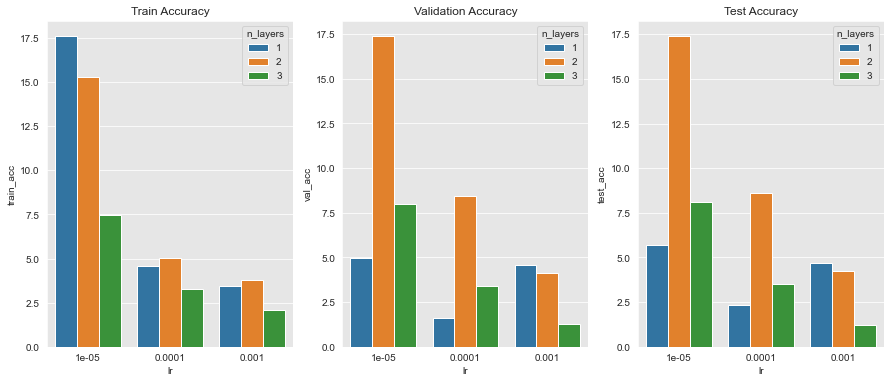

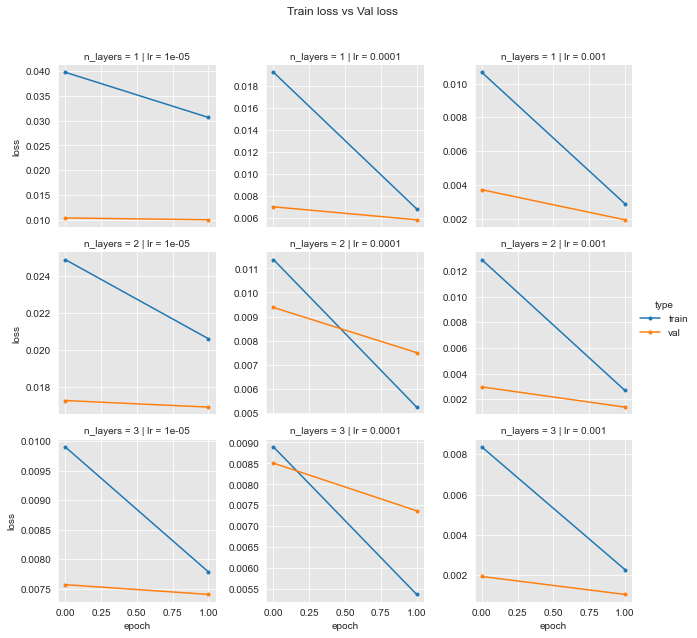

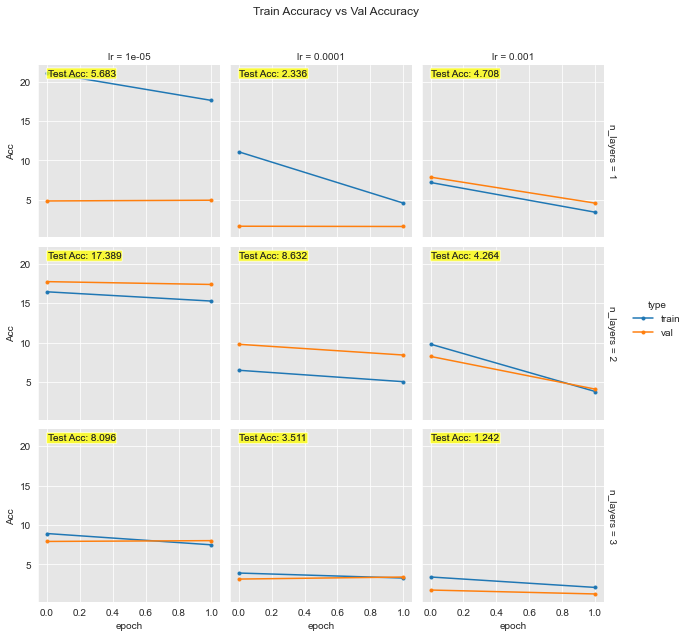

In [24]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp2')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)